[参考](https://www.kaggle.com/joaoavf/2019-05-06-iesb-miner-ii-aula-04)。



0.43717

In [109]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

df = pd.read_csv('../input/train.csv', parse_dates=[0])
test = pd.read_csv('../input/test.csv', parse_dates=[0])

In [152]:
print(df.shape, test.shape)

(10886, 18) (6493, 19)


In [110]:
# rentals 出租
df.rename(columns={'count': 'rentals'}, inplace=True)

In [111]:
df = df.append(test, sort=False)

In [112]:
# np.log1p?
for col in ['rentals', 'registered', 'casual']:
    df[col] = np.log(df[col] + 1)

In [113]:
# 年份、月份、是这个月的第几天、这个星期的第几天、小时
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour

In [114]:
df.set_index('datetime', inplace=True)

In [115]:
# df.resample('30Min')['temp'].mean().fillna(method='ffill').shape
df.sort_index(inplace=True)
df.reset_index(inplace=True)

In [116]:
df['rolling_temp'] = df['temp'].rolling(4, min_periods=1).mean()

In [117]:
test = df[df['rentals'].isnull()]
df = df[df['rentals'].notnull()]

In [118]:
removed_cols = ['rentals', 'casual', 'registered', 'datetime']

In [120]:
feats = [c for c in df.columns if c not in removed_cols]
print(feats)

['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek', 'hour', 'rolling_temp']


In [121]:
X = df[feats]
y = df['rentals']

In [122]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [124]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [126]:
from sklearn.metrics import mean_squared_error

preds = rf.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

0.2973745268552469

In [127]:
test['count'] = np.expm1(rf.predict(test[feats]))

In [128]:
# 0.44020
test[['datetime', 'count']].to_csv('../output/rf.csv', index=False)

总结：最初的模型，特征工程仅仅只是从日期时间字段中，抽取出一些时间信息，将训练数据集随机分割出验证集。

## 分离出验证集的时候，使用后半个月的数据

In [130]:
train = df[df['day'] <= 15]
valid = df[df['day'] > 15]

X_train = train[feats]
y_train = train['rentals']

X_test = valid[feats]
y_test = valid['rentals']

In [131]:
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [133]:
preds = rf.predict(X_test)

In [134]:
np.sqrt(mean_squared_error(y_test, preds))

0.3348736777502068

In [135]:
test['count'] = np.expm1(rf.predict(test[feats]))

In [136]:
# 0.43262，这个份数更好一些
test[['datetime', 'count']].to_csv('../output/rf2.csv', index=False)

## Usando OOB Score

In [137]:
rf = RandomForestRegressor(random_state=42, n_estimators=100, oob_score=True)
rf.fit( X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [140]:
rf.oob_score

True

In [141]:
rf.oob_score_

0.9559115619794903

In [139]:
rf.oob_prediction_.shape

(10886,)

In [142]:
np.sqrt(mean_squared_error(rf.oob_prediction_, df['rentals']))

0.29803261095382877

In [179]:
# k_fold

def cv(df, test, k, feats, y_name):
    preds, score, fis = [], [], []

    chunk = df.shape[0] // k

    for i in range(k):
        if i + 1 < k:
            valid = df.iloc[i * chunk:(i + 1) * chunk]
            train = df.iloc[:i * chunk].append(df.iloc[(i + 1) * chunk:])

        else:
            valid = df.iloc[i * chunk:]
            train = df.iloc[:i * chunk]

        rf = RandomForestRegressor(
            random_state=42, n_jobs=-1, n_estimators=200)

        rf.fit(train[feats], train[y_name])

        score.append(
            mean_squared_error(valid[y_name], rf.predict(valid[feats]))
            **(1 / 2))

        preds.append(rf.predict(test[feats]))

        fis.append(rf.feature_importances_)
        print(i, 'OK')
    return pd.Series(score), pd.DataFrame(preds), fis

In [180]:
score, preds, fis = cv(df, test, 5, feats, 'rentals')

0 OK
1 OK
2 OK
3 OK
4 OK


In [41]:
score.mean()

0.45851474516717633

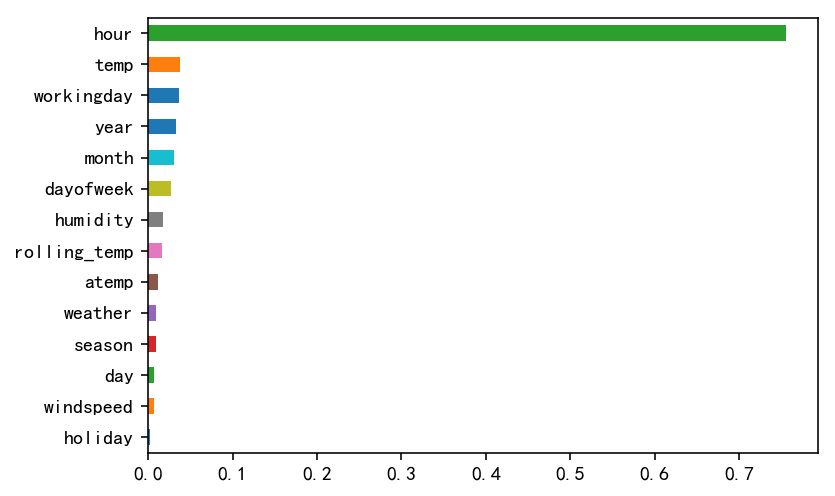

In [181]:
pd.Series(rf.feature_importances_, index=feats).sort_values().plot.barh()
plt.show()

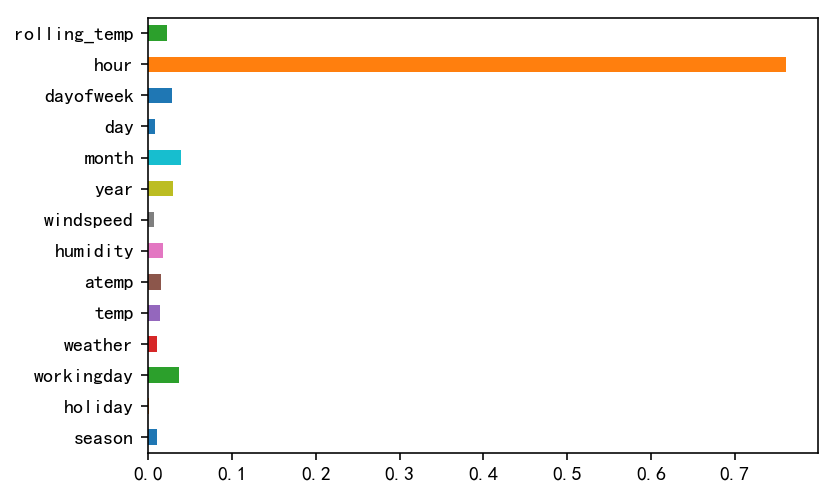

In [184]:
pd.Series(pd.DataFrame(fis, columns=feats).mean(), index=feats).plot.barh()
plt.show()

In [188]:
test['count'] = np.expm1(preds.mean().values)

In [189]:
# 0.42385
test[['datetime', 'count']].to_csv('../output/rf3.csv', index=False)